In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings('ignore')


In [2]:
demo_data = pd.read_csv("/Users/sonn/Sonn/Workspace/Projects/IonBatteryQML/data/CrystalLithiumIonBattery.csv")
demo_data.head(10)

,Materials Id,Formula,Spacegroup,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
0,mp-849394,Li2MnSiO4,Pc,-2.699,0.006,3.462,16,2.993,178.513,True,monoclinic
1,mp-783909,Li2MnSiO4,P21/c,-2.696,0.008,2.879,32,2.926,365.272,True,monoclinic
2,mp-761311,Li4MnSi2O7,Cc,-2.775,0.012,3.653,28,2.761,301.775,True,monoclinic
3,mp-761598,Li4Mn2Si3O10,C2/c,-2.783,0.013,3.015,38,2.908,436.183,True,monoclinic
4,mp-767709,Li2Mn3Si3O10,C2/c,-2.747,0.016,2.578,36,3.334,421.286,True,monoclinic
5,mp-761517,Li4MnSi2O7,C2,-2.763,0.024,3.293,14,2.792,149.207,True,monoclinic
6,mp-850949,LiMnSiO4,P21,-2.650,0.027,1.052,28,3.507,291.575,False,monoclinic
7,mp-853204,Li2MnSiO4,P21/c,-2.676,0.029,3.384,32,2.927,365.179,False,monoclinic
8,mp-767360,LiMn(SiO3)2,C2/c,-2.822,0.038,0.612,20,3.255,218.360,True,monoclinic
9,mp-764791,Li2Mn(SiO3)2,Cc,-2.823,0.040,3.447,22,2.700,271.853,True,monoclinic


In [3]:
data_show = demo_data[["Materials Id", "Formula", "Formation Energy (eV)"]]
data_show

,Materials Id,Formula,Formation Energy (eV)
0,mp-849394,Li2MnSiO4,-2.699
1,mp-783909,Li2MnSiO4,-2.696
2,mp-761311,Li4MnSi2O7,-2.775
3,mp-761598,Li4Mn2Si3O10,-2.783
4,mp-767709,Li2Mn3Si3O10,-2.747
...,...,...,...
334,mp-764961,Li6Co(SiO4)2,-2.545
335,mp-849520,LiCo3(SiO4)2,-2.250
336,mp-849656,Li5Co4(Si3O10)2,-2.529
337,mp-763557,LiCoSiO4,-2.348


In [4]:
ATOMIC_PROPERTIES = {
    'Li': {'mass': 6.94, 'radius': 1.52, 'electronegativity': 0.98, 'valence': 1, 'density': 0.534},
    'Fe': {'mass': 55.845, 'radius': 1.26, 'electronegativity': 1.83, 'valence': 2, 'density': 7.874},
    'Co': {'mass': 58.933, 'radius': 1.25, 'electronegativity': 1.88, 'valence': 2, 'density': 8.90},
    'Mn': {'mass': 54.938, 'radius': 1.27, 'electronegativity': 1.55, 'valence': 2, 'density': 7.21},
    'Si': {'mass': 28.085, 'radius': 1.11, 'electronegativity': 1.90, 'valence': 4, 'density': 2.33},
    'O': {'mass': 15.999, 'radius': 0.66, 'electronegativity': 3.44, 'valence': 2, 'density': 1.429},
    'S': {'mass': 32.066, 'radius': 1.05, 'electronegativity': 2.58, 'valence': 2, 'density': 2.07},
    'P': {'mass': 30.974, 'radius': 1.07, 'electronegativity': 2.19, 'valence': 3, 'density': 1.82},
    'C': {'mass': 12.011, 'radius': 0.70, 'electronegativity': 2.55, 'valence': 4, 'density': 2.27}
}

class PhysicsInformedFeatureExtractor:
    """Extract physics-informed features from chemical formulas and crystal properties"""
    
    def parse_formula(self, formula):
        """Parse chemical formula to extract element composition"""
        # Handle parentheses first
        formula = re.sub(r'\(([^)]+)\)(\d+)', lambda m: m.group(1) * int(m.group(2)), formula)
        
        # Extract elements and their counts
        pattern = r'([A-Z][a-z]?)(\d*)'
        matches = re.findall(pattern, formula)
        
        composition = defaultdict(int)
        for element, count in matches:
            count = int(count) if count else 1
            composition[element] += count
            
        return dict(composition)
    
    def extract_elemental_features(self, formula):
        """Extract physics-based features from elemental composition"""
        composition = self.parse_formula(formula)
        total_atoms = sum(composition.values())
        
        features = {}
        for element in ['Li', 'Fe', 'Co', 'Mn', 'Si', 'O', 'S', 'P', 'C']:
            features[f'{element}_ratio'] = composition.get(element, 0) / total_atoms

        total_mass = 0
        total_radius = 0
        total_electronegativity = 0
        total_valence = 0
        total_atomic_density = 0
        
        for element, count in composition.items():
            if element in ATOMIC_PROPERTIES:
                props = ATOMIC_PROPERTIES[element]
                weight = count / total_atoms
                
                total_mass += props['mass'] * count
                total_radius += props['radius'] * weight
                total_electronegativity += props['electronegativity'] * weight
                total_valence += props['valence'] * weight
                total_atomic_density += props['density'] * weight
        
        features['molecular_weight'] = total_mass
        features['avg_atomic_radius'] = total_radius
        features['avg_electronegativity'] = total_electronegativity
        features['avg_valence'] = total_valence
        features['avg_atomic_density'] = total_atomic_density
        
        features['total_atoms'] = total_atoms
        features['Li_to_transition_metal_ratio'] = (
            composition.get('Li', 0) / 
            max(composition.get('Fe', 0) + composition.get('Co', 0) + composition.get('Mn', 0), 1)
        )
        features['oxygen_to_metal_ratio'] = (
            composition.get('O', 0) / 
            max(sum(composition.get(metal, 0) for metal in ['Li', 'Fe', 'Co', 'Mn', 'Si']), 1)
        )
        
        return features
    
    def extract_physics_features(self, row):
        """Extract additional physics-informed features"""
        features = {}
        
        # Energy-based features
        features['formation_energy_per_atom'] = row['Formation Energy (eV)'] / row['Nsites']
        features['energy_above_hull_per_atom'] = row['E Above Hull (eV)'] / row['Nsites']
        
        # Structure-property relationships
        features['volume_per_atom'] = row['Volume'] / row['Nsites']
        features['packing_efficiency'] = row['Nsites'] / row['Volume']  # atoms per unit volume
        
        # Electronic properties
        features['band_gap_normalized'] = row['Band Gap (eV)'] / np.log(row['Volume'] + 1)
        
        # Stability indicators
        features['thermodynamic_stability'] = -row['Formation Energy (eV)']  # more negative = more stable
        features['phase_stability'] = 1 / (row['E Above Hull (eV)'] + 0.001)  # avoid division by zero
        
        # Crystal system encoding (one-hot style features)
        crystal_systems = ['triclinic', 'monoclinic', 'orthorhombic', 'tetragonal', 'cubic', 'hexagonal']
        for system in crystal_systems:
            features[f'is_{system}'] = 1 if row['Crystal System'].lower() == system else 0
        
        return features

def load_and_preprocess_data(csv_path):
    """Load and preprocess the crystal data"""
    
    print("Note: Using sample data for demonstration.")
    print("Replace this section with: df = pd.read_csv('CrystalClassificationLithiumIonBattery.csv')")
    
   
    # df = pd.read_csv(csv_path)
    df = pd.read_csv('/Users/sonn/Sonn/Workspace/Projects/IonBatteryQML/data/CrystalLithiumIonBattery.csv')
    
    return df

def create_feature_matrix(df):
    """Create comprehensive feature matrix with physics-informed features"""
    extractor = PhysicsInformedFeatureExtractor()
    all_features = []
    for idx, row in df.iterrows():
        elemental_features = extractor.extract_elemental_features(row['Formula'])
        physics_features = extractor.extract_physics_features(row)
        combined_features = {**elemental_features, **physics_features}
        all_features.append(combined_features)
    
    
    feature_df = pd.DataFrame(all_features)
    
    return feature_df

def train_models(X, y):
    """Train multiple models and compare performance"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Ridge Regression': Ridge(alpha=1.0),
        'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

    }
    
    results = {}
    
    for name, model in models.items():
        if name in ['Ridge Regression', 'Elastic Net']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            X_cv = X_train_scaled
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            X_cv = X_train
        
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='r2')
        
        results[name] = {
            'model': model,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'actual': y_test
        }
        
        print(f"\n{name} Results:")
        print(f"  R² Score: {r2:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  CV R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return results, scaler

def analyze_feature_importance(best_model, feature_names):
    """Analyze and visualize feature importance"""
    if hasattr(best_model, 'feature_importances_'):
        importance = best_model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        print("\nTop 15 Most Important Features:")
        print(feature_importance.head(15))
        
        # Plot feature importance
        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
        plt.title('Top 15 Physics-Informed Features for Density Prediction')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()
        
        return feature_importance
    else:
        print("Feature importance not available for this model type")
        return None

def plot_predictions(results):
    """Plot actual vs predicted values for all models"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for idx, (name, result) in enumerate(results.items()):
        ax = axes[idx]
        ax.scatter(result['actual'], result['predictions'], alpha=0.6)
        
        # Perfect prediction line
        min_val = min(min(result['actual']), min(result['predictions']))
        max_val = max(max(result['actual']), max(result['predictions']))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        ax.set_xlabel('Giá trị thực')
        ax.set_ylabel('Giá trị dự đoán')
        ax.set_title(f'{name}\nR² = {result["r2"]:.4f}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



In [5]:
df = load_and_preprocess_data(None)


Note: Using sample data for demonstration.
Replace this section with: df = pd.read_csv('CrystalClassificationLithiumIonBattery.csv')


In [6]:
feature_matrix = create_feature_matrix(df)

In [7]:
X = feature_matrix.drop(columns=["formation_energy_per_atom","energy_above_hull_per_atom","volume_per_atom","packing_efficiency", "band_gap_normalized","thermodynamic_stability","phase_stability"])
# y = df['Density (gm/cc)']
y = df['Formation Energy (eV)']

In [8]:
X_df = pd.DataFrame(X, columns=X.columns)
X.head(5)

,Li_ratio,Fe_ratio,Co_ratio,Mn_ratio,Si_ratio,O_ratio,S_ratio,P_ratio,C_ratio,molecular_weight,...,avg_atomic_density,total_atoms,Li_to_transition_metal_ratio,oxygen_to_metal_ratio,is_triclinic,is_monoclinic,is_orthorhombic,is_tetragonal,is_cubic,is_hexagonal
0,0.250000,0.0,0.0,0.125000,0.125000,0.500000,0.0,0.0,0.0,160.899,...,2.040500,8,2.000000,1.000000,0,1,0,0,0,0
1,0.250000,0.0,0.0,0.125000,0.125000,0.500000,0.0,0.0,0.0,160.899,...,2.040500,8,2.000000,1.000000,0,1,0,0,0,0
2,0.285714,0.0,0.0,0.071429,0.142857,0.500000,0.0,0.0,0.0,250.861,...,1.714929,14,4.000000,1.000000,0,1,0,0,0,0
3,0.210526,0.0,0.0,0.105263,0.157895,0.526316,0.0,0.0,0.0,381.881,...,1.991368,19,2.000000,1.111111,0,1,0,0,0,0
4,0.111111,0.0,0.0,0.166667,0.166667,0.555556,0.0,0.0,0.0,422.939,...,2.443222,18,0.666667,1.250000,0,1,0,0,0,0


In [9]:
print(f"Generated {len(feature_matrix.columns)} physics-informed features:")

Generated 30 physics-informed features:


In [10]:
feature_matrix.to_csv('/Users/sonn/Sonn/Workspace/Projects/IonBatteryQML/data/CrystalLithiumIonBattery_Physics_Informed_Features.csv', index=False)

In [11]:
feature_matrix.head(5)

,Li_ratio,Fe_ratio,Co_ratio,Mn_ratio,Si_ratio,O_ratio,S_ratio,P_ratio,C_ratio,molecular_weight,...,packing_efficiency,band_gap_normalized,thermodynamic_stability,phase_stability,is_triclinic,is_monoclinic,is_orthorhombic,is_tetragonal,is_cubic,is_hexagonal
0,0.250000,0.0,0.0,0.125000,0.125000,0.500000,0.0,0.0,0.0,160.899,...,0.089629,0.667020,2.699,142.857143,0,1,0,0,0,0
1,0.250000,0.0,0.0,0.125000,0.125000,0.500000,0.0,0.0,0.0,160.899,...,0.087606,0.487687,2.696,111.111111,0,1,0,0,0,0
2,0.285714,0.0,0.0,0.071429,0.142857,0.500000,0.0,0.0,0.0,250.861,...,0.092784,0.639420,2.775,76.923077,0,1,0,0,0,0
3,0.210526,0.0,0.0,0.105263,0.157895,0.526316,0.0,0.0,0.0,381.881,...,0.087119,0.495859,2.783,71.428571,0,1,0,0,0,0
4,0.111111,0.0,0.0,0.166667,0.166667,0.555556,0.0,0.0,0.0,422.939,...,0.085453,0.426420,2.747,58.823529,0,1,0,0,0,0


In [12]:
# Li_ratio,Fe_ratio,Co_ratio,Mn_ratio,Si_ratio,O_ratio,S_ratio,P_ratio,C_ratio,molecular_weight,avg_atomic_radius,avg_electronegativity,avg_valence,avg_atomic_density,total_atoms,Li_to_transition_metal_ratio,oxygen_to_metal_ratio,is_triclinic,is_monoclinic,is_orthorhombic,is_tetragonal,is_cubic,is_hexagonal

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Machine learning

Random Forest

In [14]:
rf = RandomForestRegressor(random_state=42)

param_grid = {

    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)

y_pred = grid_search.predict(X_test_scaled)

print("R2 score: ", r2_score(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, 

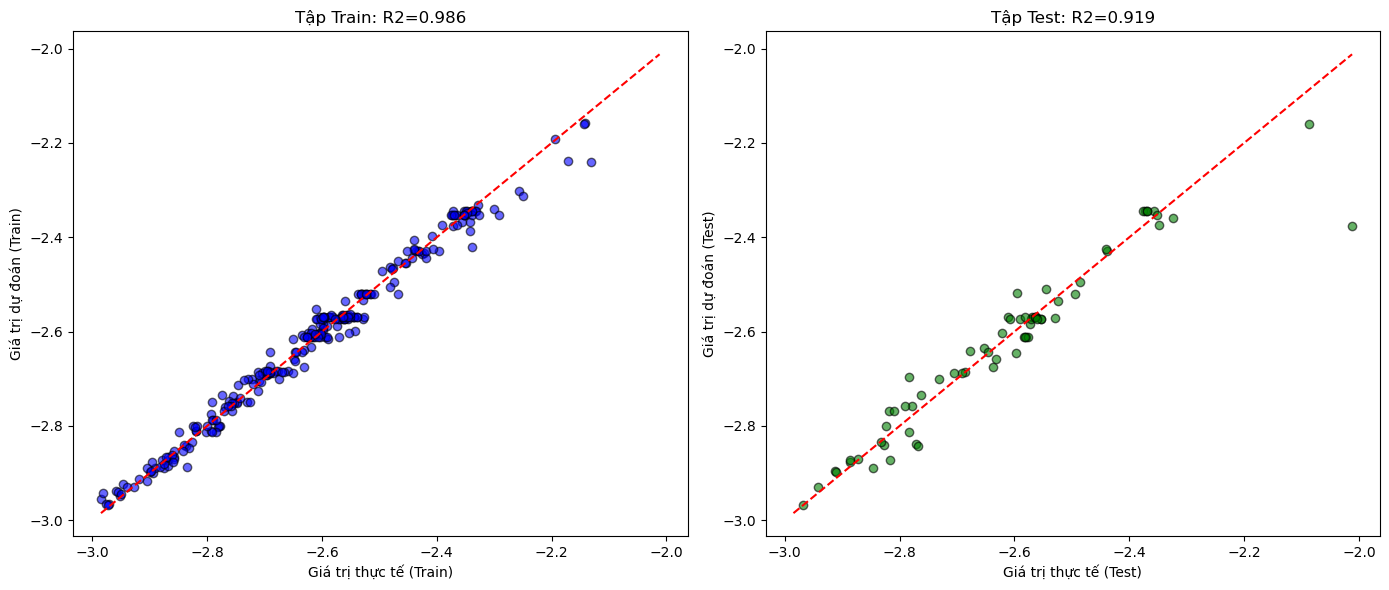

In [15]:
y_train_pred = grid_search.predict(X_train_scaled)

plt.figure(figsize=(14, 6))

# Plot tập train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Train)')
plt.ylabel('Giá trị dự đoán (Train)')
plt.title(f'Tập Train: R2={r2_score(y_train, y_train_pred):.3f}')

# Plot tập test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='green', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Test)')
plt.ylabel('Giá trị dự đoán (Test)')
plt.title(f'Tập Test: R2={r2_score(y_test, y_pred):.3f}')

plt.tight_layout()
plt.show()

PCA-RF

In [16]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


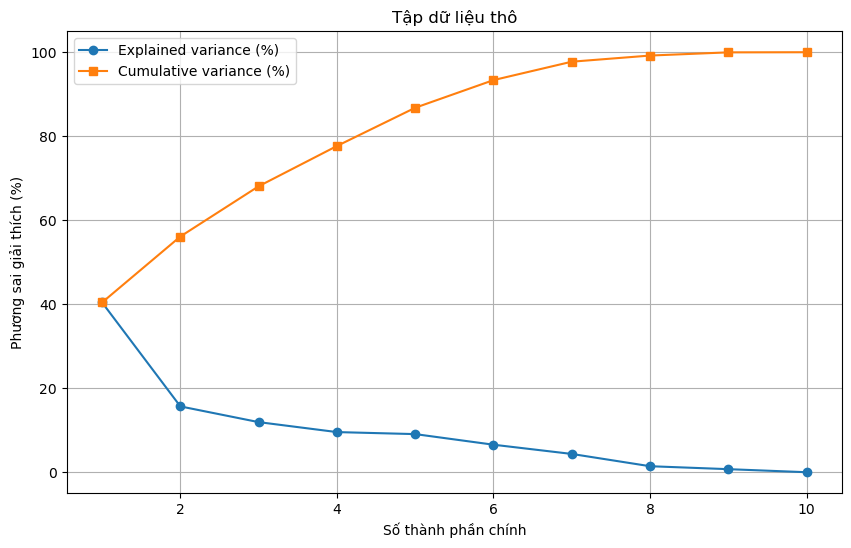

In [17]:
# Phần trăm phương sai giải thích được
pca = PCA(10)
pca.fit(X_train_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio*100, marker='o', label='Explained variance (%)')
plt.plot(range(1, len(explained_variance_ratio)+1), cumulative_variance_ratio*100, marker='s', label='Cumulative variance (%)')
plt.xlabel('Số thành phần chính')
plt.ylabel('Phương sai giải thích (%)')
plt.title('Tập dữ liệu thô')
plt.legend()
plt.grid(True)
plt.show()

In [18]:

pipe = Pipeline([
    ('pca', PCA()),                        
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'pca__n_components': [4, 5, 6, 7, 8, 9, 10],          
    'rf__n_estimators': [100, 200],               
    'rf__max_depth': [None, 10, 20],               
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,                        
    scoring='r2',               
    n_jobs=-1                  
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best CV Score (R²):", grid_search.best_score_)

# Đánh giá trên test set
y_pred = grid_search.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))



Best Params: {'pca__n_components': 10, 'rf__max_depth': None, 'rf__n_estimators': 100}
Best CV Score (R²): 0.8479298768116001
Test R²: 0.9134081712249036


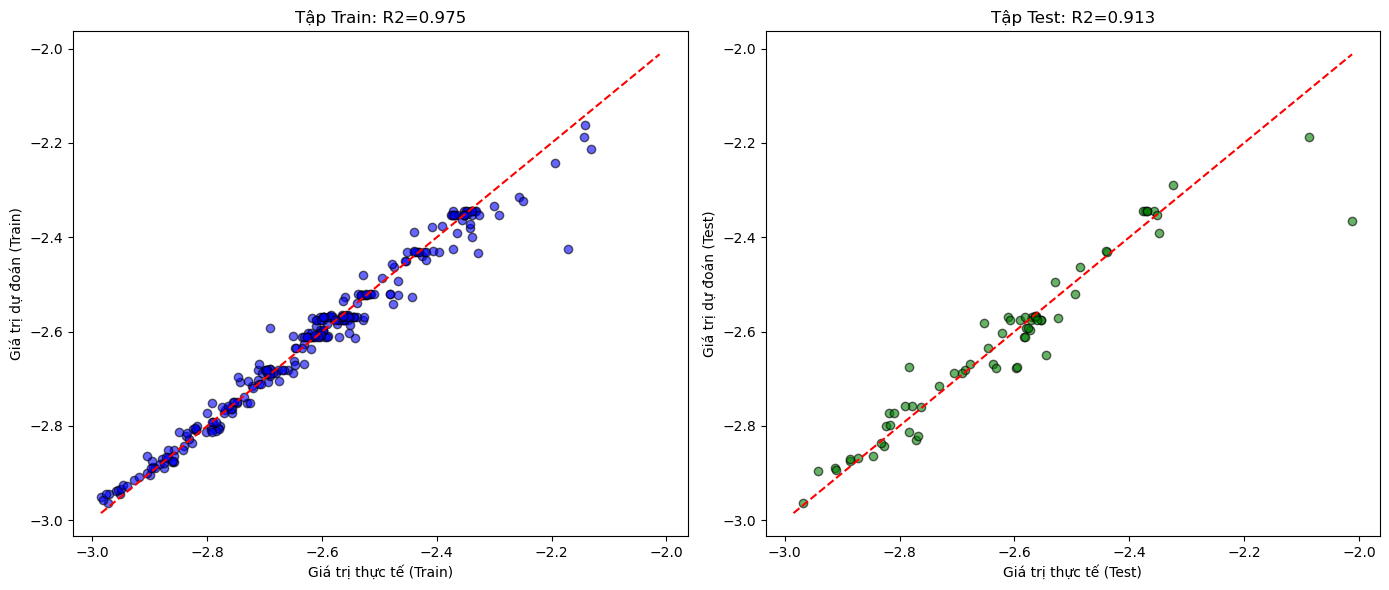

In [19]:
y_train_pred = grid_search.predict(X_train)

plt.figure(figsize=(14, 6))

# Plot tập train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Train)')
plt.ylabel('Giá trị dự đoán (Train)')
plt.title(f'Tập Train: R2={r2_score(y_train, y_train_pred):.3f}')

# Plot tập test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='green', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Test)')
plt.ylabel('Giá trị dự đoán (Test)')
plt.title(f'Tập Test: R2={r2_score(y_test, y_pred):.3f}')

plt.tight_layout()
plt.show()

VAE-RF

In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt

# # =========================
# # 1. DEFINE VAE MODULE
# # =========================
# class VAE(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(VAE, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc21 = nn.Linear(64, latent_dim)
#         self.fc22 = nn.Linear(64, latent_dim)
#         self.fc3 = nn.Linear(latent_dim, 64)
#         self.fc4 = nn.Linear(64, input_dim)

#     def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         return self.fc4(h3)

#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar

# def vae_loss(recon_x, x, mu, logvar):
#     recon_loss = F.mse_loss(recon_x, x, reduction='sum')
#     kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return recon_loss + kl_loss

# def train_vae(model, data_loader, epochs=50, lr=1e-3):
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     model.train()
#     for epoch in range(epochs):
#         total_loss = 0
#         for batch in data_loader:
#             x = batch[0]
#             recon_x, mu, logvar = model(x)
#             loss = vae_loss(recon_x, x, mu, logvar)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.2f}")

# def extract_latent(model, X_tensor):
#     model.eval()
#     with torch.no_grad():
#         mu, _ = model.encode(X_tensor)
#     return mu.cpu().numpy()


# # =========================
# # 3. PREPROCESSING
# # =========================
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y, test_size=0.2, random_state=42
# )

# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

# train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

# # =========================
# # 4. VAE TRAINING
# # =========================
# latent_dim = 10
# vae = VAE(input_dim=X.shape[1], latent_dim=latent_dim)
# train_vae(vae, train_loader, epochs=50)

# # =========================
# # 5. EXTRACT LATENT z
# # =========================
# z_train = extract_latent(vae, X_train_tensor)
# z_test  = extract_latent(vae, X_test_tensor)

# # =========================
# # 6. GRIDSEARCH + RF
# # =========================
# param_grid = {
#     'n_estimators': [3, 4, 5, 6, 10, 12, 15],
#     'max_depth': [None, 10, 20]
# }

# grid = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     param_grid=param_grid,
#     cv=5,
#     scoring='r2',
#     n_jobs=-1
# )

# grid.fit(z_train, y_train)
# y_pred = grid.predict(z_test)

# # =========================
# # 7. RESULTS + PLOT
# # =========================
# print("Best Params:", grid.best_params_)
# print("Train CV R²:", grid.best_score_)
# print("Test R² Score:", r2_score(y_test, y_pred))

# y_train_pred = grid.predict(z_train)

# plt.figure(figsize=(14, 6))

# # Plot tập train
# plt.subplot(1, 2, 1)
# plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, edgecolor='k')
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
# plt.xlabel('Giá trị thực tế (Train)')
# plt.ylabel('Giá trị dự đoán (Train)')
# plt.title(f'Tập Train: R2={r2_score(y_train, y_train_pred):.3f}')

# # Plot tập test
# plt.subplot(1, 2, 2)
# plt.scatter(y_test, y_pred, color='green', alpha=0.6, edgecolor='k')
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
# plt.xlabel('Giá trị thực tế (Test)')
# plt.ylabel('Giá trị dự đoán (Test)')
# plt.title(f'Tập Test: R2={r2_score(y_test, y_pred):.3f}')

# plt.tight_layout()
# plt.show()


ImportError: dlopen(/Users/sonn/anaconda3/envs/WSAIPytorch3.11/lib/python3.11/site-packages/torch/_C.cpython-311-darwin.so, 0x0002): Symbol not found: __ZN2at3cpu21is_amx_fp16_supportedEv
  Referenced from: <F6CBCBF9-CBEF-3715-8CA0-397B850E3FB8> /Users/sonn/anaconda3/envs/WSAIPytorch3.11/lib/python3.11/site-packages/torch/lib/libtorch_python.dylib
  Expected in:     <1F1D80B0-A695-3C81-AD64-A520121567F5> /Users/sonn/anaconda3/envs/WSAIPytorch3.11/lib/libtorch_cpu.dylib

Deep learning

MLP

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


In [ ]:
mlp = MLPRegressor(max_iter=1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3],  # L2 regularization
    'learning_rate_init': [1e-3, 1e-2]
}


In [ ]:
grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train)
y_pred = grid.predict(X_test_scaled)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
print("Best Params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)
print("Test R²:", r2_score(y_test, y_pred))

# Plot dự đoán



Best Params: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}
Best CV R²: 0.8108861222309216
Test R²: 0.9294002517680677


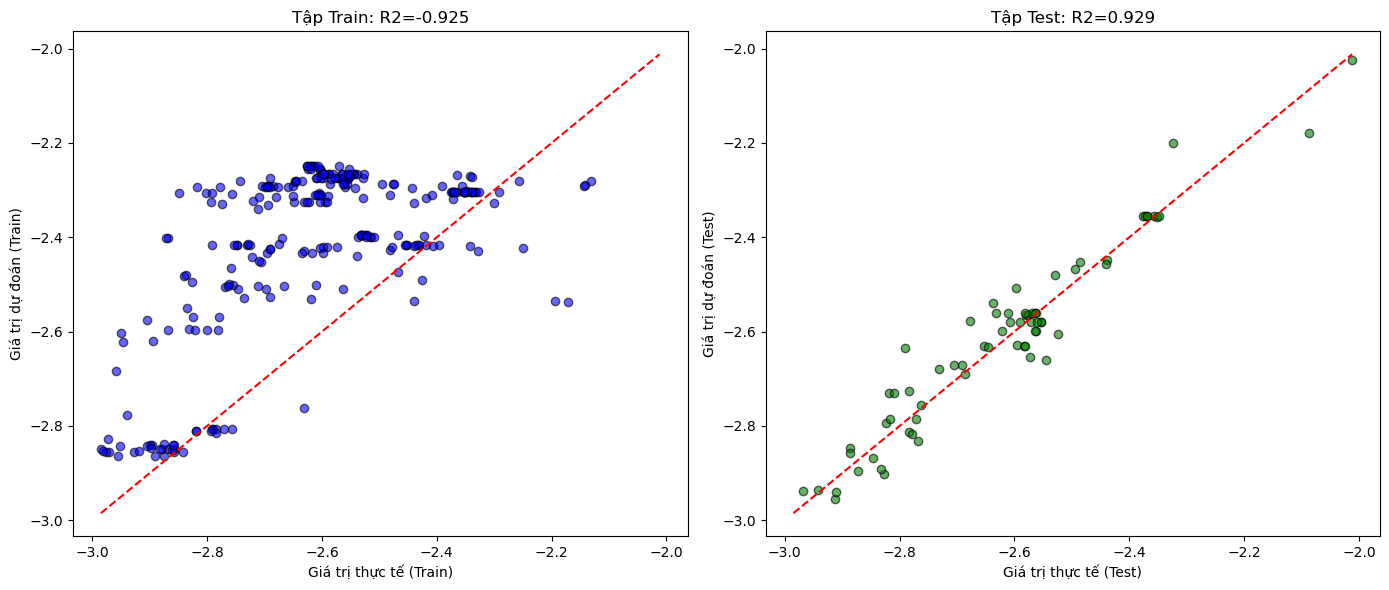

In [ ]:
y_train_pred = grid_search.predict(X_train_scaled)

plt.figure(figsize=(14, 6))

# Plot tập train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Train)')
plt.ylabel('Giá trị dự đoán (Train)')
plt.title(f'Tập Train: R2={r2_score(y_train, y_train_pred):.3f}')

# Plot tập test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='green', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Test)')
plt.ylabel('Giá trị dự đoán (Test)')
plt.title(f'Tập Test: R2={r2_score(y_test, y_pred):.3f}')

plt.tight_layout()
plt.show()

PCA-MLP

In [ ]:

pipe = Pipeline([
    ('pca', PCA()),                        
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

param_grid = {
    'pca__n_components': [4, 5, 6, 7, 8, 9, 10],          
    'mlp__hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [1e-4, 1e-3],  # L2 regularization
    'mlp__learning_rate_init': [1e-3, 1e-2]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,                        
    scoring='r2',               
    n_jobs=-1                  
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best CV Score (R²):", grid_search.best_score_)

# Đánh giá trên test set
y_pred = grid_search.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))



Best Params: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (128, 64), 'mlp__learning_rate_init': 0.01, 'pca__n_components': 9}
Best CV Score (R²): 0.831882966291426
Test R²: 0.8684101359739088


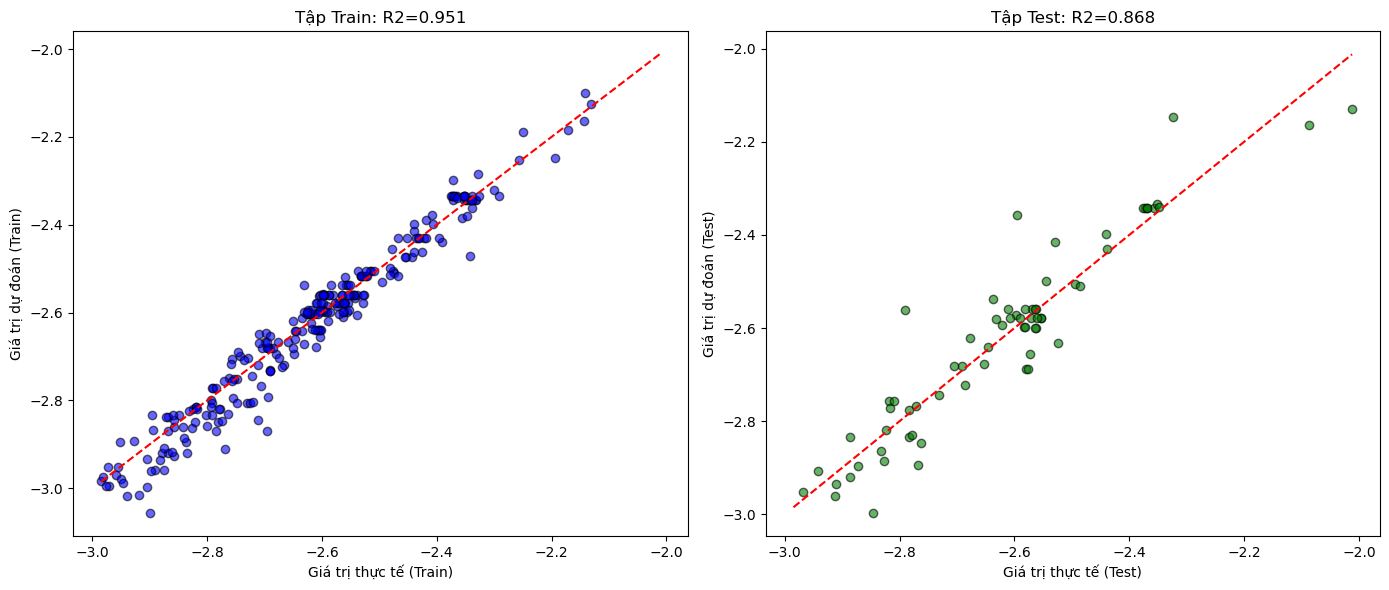

In [ ]:
y_train_pred = grid_search.predict(X_train)

plt.figure(figsize=(14, 6))

# Plot tập train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Train)')
plt.ylabel('Giá trị dự đoán (Train)')
plt.title(f'Tập Train: R2={r2_score(y_train, y_train_pred):.3f}')

# Plot tập test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='green', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Test)')
plt.ylabel('Giá trị dự đoán (Test)')
plt.title(f'Tập Test: R2={r2_score(y_test, y_pred):.3f}')

plt.tight_layout()
plt.show()

VAE-MLP

Epoch 1/50 - Loss: 5037.53
Epoch 2/50 - Loss: 4902.33
Epoch 3/50 - Loss: 4792.33
Epoch 4/50 - Loss: 4727.36
Epoch 5/50 - Loss: 4637.96
Epoch 6/50 - Loss: 4621.43
Epoch 7/50 - Loss: 4531.84
Epoch 8/50 - Loss: 4481.83
Epoch 9/50 - Loss: 4330.30
Epoch 10/50 - Loss: 4157.54
Epoch 11/50 - Loss: 4031.40
Epoch 12/50 - Loss: 3860.24
Epoch 13/50 - Loss: 3742.85
Epoch 14/50 - Loss: 3715.81
Epoch 15/50 - Loss: 3677.85
Epoch 16/50 - Loss: 3543.32
Epoch 17/50 - Loss: 3456.54
Epoch 18/50 - Loss: 3442.99
Epoch 19/50 - Loss: 3448.01
Epoch 20/50 - Loss: 3487.97
Epoch 21/50 - Loss: 3424.46
Epoch 22/50 - Loss: 3440.81
Epoch 23/50 - Loss: 3366.26
Epoch 24/50 - Loss: 3331.27
Epoch 25/50 - Loss: 3263.33
Epoch 26/50 - Loss: 3222.35
Epoch 27/50 - Loss: 3202.30
Epoch 28/50 - Loss: 3155.28
Epoch 29/50 - Loss: 3172.50
Epoch 30/50 - Loss: 3117.94
Epoch 31/50 - Loss: 3073.15
Epoch 32/50 - Loss: 3075.83
Epoch 33/50 - Loss: 3023.93
Epoch 34/50 - Loss: 2927.07
Epoch 35/50 - Loss: 2887.13
Epoch 36/50 - Loss: 2947.42
E

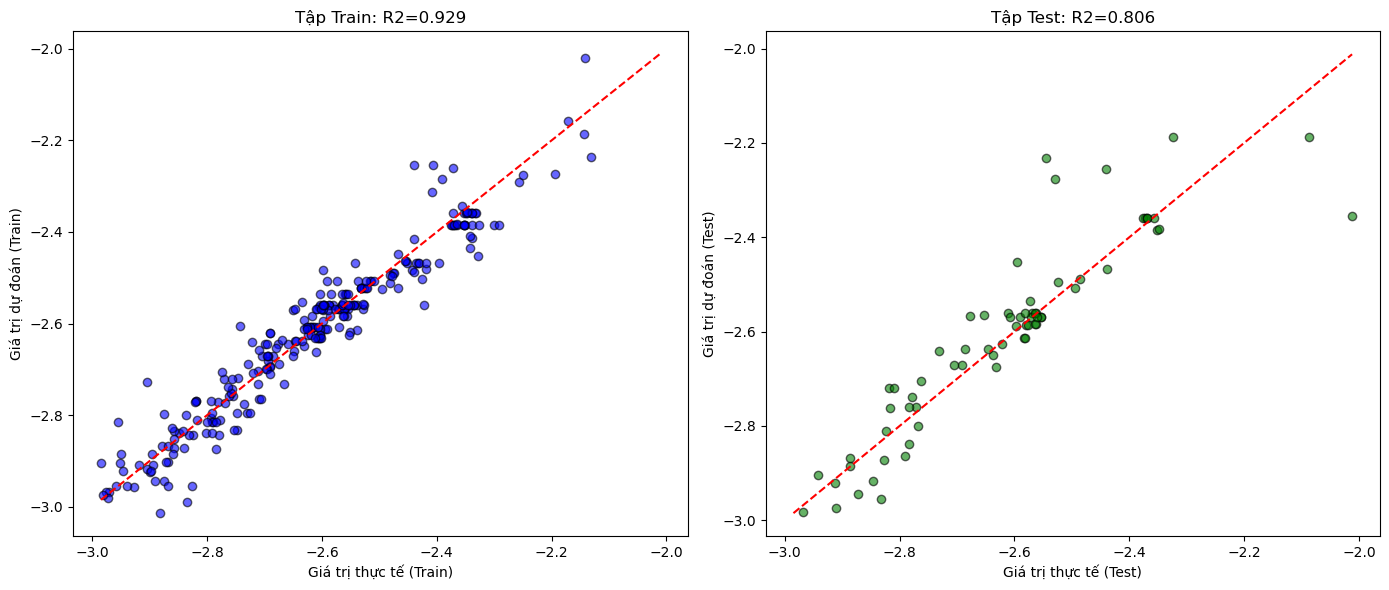

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ================================
# 1. Define VAE model
# ================================
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc21 = nn.Linear(64, latent_dim)
        self.fc22 = nn.Linear(64, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 64)
        self.fc4 = nn.Linear(64, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def train_vae(model, data_loader, epochs=50, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            x = batch[0]
            recon_x, mu, logvar = model(x)
            loss = vae_loss(recon_x, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.2f}")

def extract_latent(model, X_tensor):
    model.eval()
    with torch.no_grad():
        mu, _ = model.encode(X_tensor)
    return mu.cpu().numpy()



X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

# ================================
# 4. Train VAE
# ================================
latent_dim = 10
vae = VAE(input_dim=X.shape[1], latent_dim=latent_dim)
train_vae(vae, train_loader, epochs=50)

# ================================
# 5. Extract latent features
# ================================
z_train = extract_latent(vae, X_train_tensor)
z_test  = extract_latent(vae, X_test_tensor)

# ================================
# 6. MLP Regressor + GridSearchCV
# ================================
mlp = MLPRegressor(max_iter=1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [1e-3, 1e-2]
}

grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid.fit(z_train, y_train)
y_pred = grid.predict(z_test)

# ================================
# 7. Evaluation & Plot
# ================================
print("Best Parameters:", grid.best_params_)
print("CV R² Score:", grid.best_score_)
print("Test R² Score:", r2_score(y_test, y_pred))

y_train_pred = grid.predict(z_train)

plt.figure(figsize=(14, 6))

# Plot tập train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Train)')
plt.ylabel('Giá trị dự đoán (Train)')
plt.title(f'Tập Train: R2={r2_score(y_train, y_train_pred):.3f}')

# Plot tập test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='green', alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Giá trị thực tế (Test)')
plt.ylabel('Giá trị dự đoán (Test)')
plt.title(f'Tập Test: R2={r2_score(y_test, y_pred):.3f}')

plt.tight_layout()
plt.show()


Demo

In [ ]:
results, scaler = train_models(X, y)


Random Forest Results:
  R² Score: 0.9225
  RMSE: 0.0531
  MAE: 0.0296
  CV R² (mean ± std): 0.9088 ± 0.0488

Gradient Boosting Results:
  R² Score: 0.9243
  RMSE: 0.0525
  MAE: 0.0268
  CV R² (mean ± std): 0.9438 ± 0.0241

Ridge Regression Results:
  R² Score: 0.9664
  RMSE: 0.0349
  MAE: 0.0273
  CV R² (mean ± std): 0.9552 ± 0.0101

Elastic Net Results:
  R² Score: 0.7197
  RMSE: 0.1009
  MAE: 0.0771
  CV R² (mean ± std): 0.7126 ± 0.0388


In [ ]:
best_model_name = max(results.keys(), key=lambda k: results[k]['r2'])
best_model = results[best_model_name]['model']

In [ ]:
print(f"\nBest Model: {best_model_name}")
print(f"Test R² Score: {results[best_model_name]['r2']:.4f}")


Best Model: Ridge Regression
Test R² Score: 0.9664


In [ ]:
# analyze_feature_importance(best_model, feature_matrix.columns)

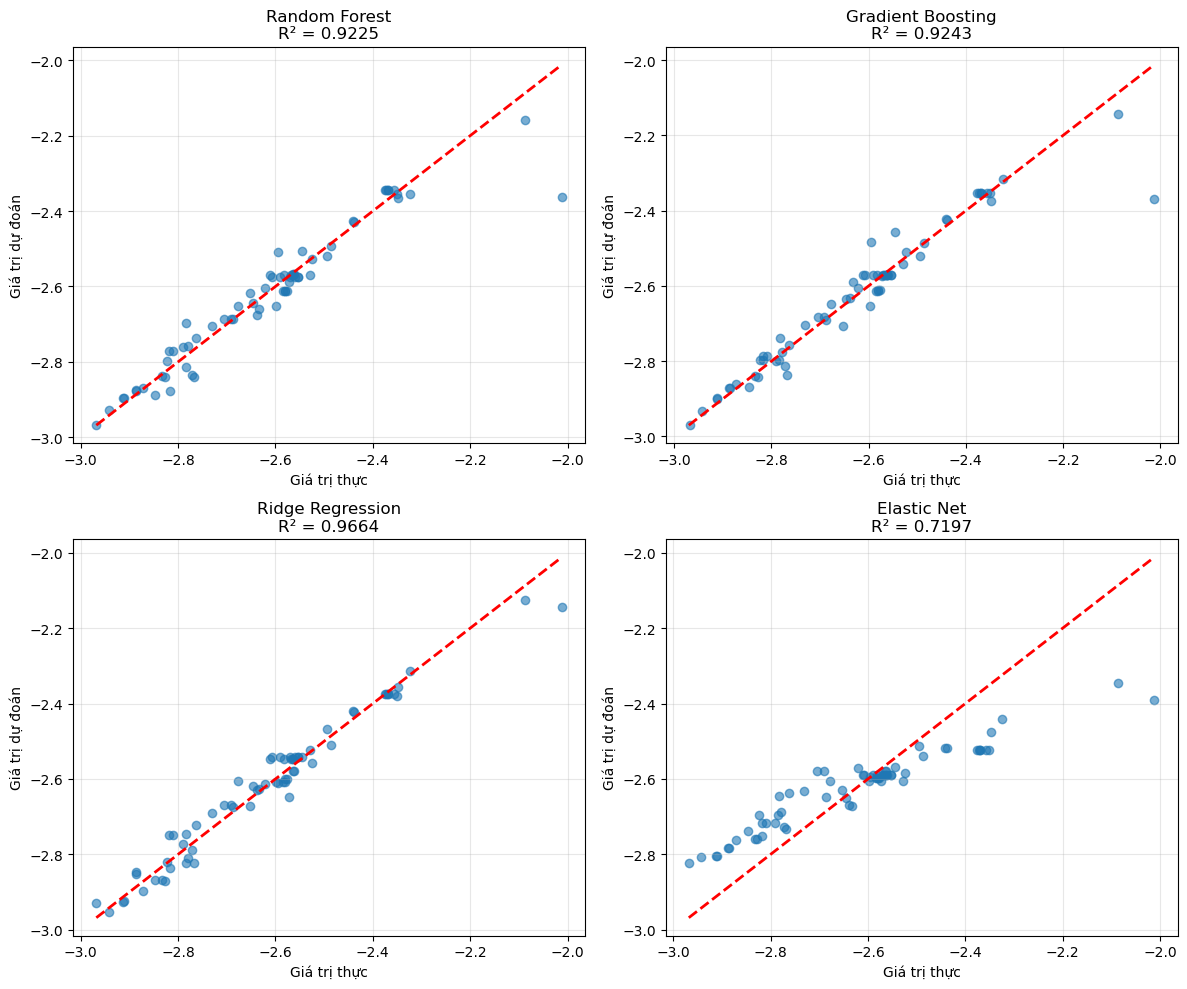

In [ ]:
plot_predictions(results)